In [2]:
import os

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
import numpy as np
import torch
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

In [5]:
dataset_dir = "./mnist/"
metadata_file = "mnist.csv"
metadata_path = os.path.join(dataset_dir, metadata_file)

metadata = pd.read_csv(metadata_path)

In [6]:
metadata.head()

,id,filename,label
0,0,00000.png,5
1,1,00001.png,0
2,2,00002.png,4
3,3,00003.png,1
4,4,00004.png,9


In [9]:
metadata["filename"][0]

'00000.png'

In [10]:
# create a tensor with all the images
images = []
transform = transforms.ToTensor()

for path in metadata["filename"]:
    img = Image.open(os.path.join(dataset_dir, path))
    tensor_image = transform(img)
    images.append(tensor_image)

all_images = torch.stack(images)

KeyboardInterrupt: 

In [ ]:
all_images.size()

torch.Size([70000, 1, 28, 28])

In [ ]:
# normalize the all_images tensor to have zero mean and 1 std dev
all_images = all_images.float()
mean = all_images.mean()
std = all_images.std()
all_images = (all_images - mean) / std

In [ ]:
print(f"mean: {mean}, std: {std}")

mean: 0.13092535734176636, std: 0.30844852328300476


In [ ]:
import torch.nn.functional as F

In [ ]:
# upsample the images to 32x32
upsampled_images = F.interpolate(all_images, size=32)

In [ ]:
upsampled_images.size()

torch.Size([70000, 1, 32, 32])

# Inference

In [4]:
from src.model import Unet

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
model_pth = "models/model_epoch_500.pth"
model = Unet(c_start=1)
model.load_state_dict(torch.load(model_pth))
model.to(device)
model.eval()


Unet(
  (learnable_embedding_block): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (initial_conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downblocks): ModuleList(
    (0): Resnet(
      (pre_timestep_block): Sequential(
        (0): GroupNorm(4, 16, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (timestep_block): Sequential(
        (0): GroupNorm(4, 256, eps=1e-05, affine=True)
        (1): Linear(in_features=256, out_features=32, bias=True)
      )
      (post_timestep_block): Sequential(
        (0): GroupNorm(4, 32, eps=1e-05, affine=True)
        (1): SiLU()
        (2): Dropout(p=0.1, inplace=False)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (identity_conv): Con

In [8]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 8.685MB


In [10]:
t = torch.cuda.get_device_properties(0).total_memory / 1024**2
r = torch.cuda.memory_reserved(0) / 1024**2
a = torch.cuda.memory_allocated(0) / 1024**2
f = r-a  # free inside reserved
print(f'total: {t:.3g}, reserved: {r:.3g}, allocated: {a:.3g}, free: {f:.3g}')


total: 1.51e+04, reserved: 10, allocated: 8.7, free: 1.3


In [7]:
from train import (
    betas,
    alphas,
    T,
    in_c,
    in_h,
    in_w,
)

In [21]:
betas = betas.to(device)
alphas = alphas.to(device)

In [18]:
import torch.nn as nn


def sample_next_step(
    x_t: torch.Tensor,
    t: torch.Tensor,
    model: nn.Module,
) -> torch.Tensor:
    """
    sample x_{t-1} given x_t and x_0
    """
    assert 2 <= t and t < T, f"time index {t} must be in range [2, {T}]"
    beta_t = betas[t - 1]
    alpha_t = alphas[t - 1]
    alpha_t_1 = alphas[t - 2]

    # conditional mean and variance
    mu_t = (x_t - (beta_t / torch.sqrt(1 - alpha_t)) * model(x_t, t)) / torch.sqrt(
        1 - beta_t
    )
    sigma_t = torch.sqrt((1 - alpha_t_1) / (1 - alpha_t) * beta_t)

    return mu_t + sigma_t * torch.randn_like(mu_t)

In [1]:
import matplotlib.pyplot as plt

foo
image at t: tensor([[802]], device='cuda:0', dtype=torch.int32)


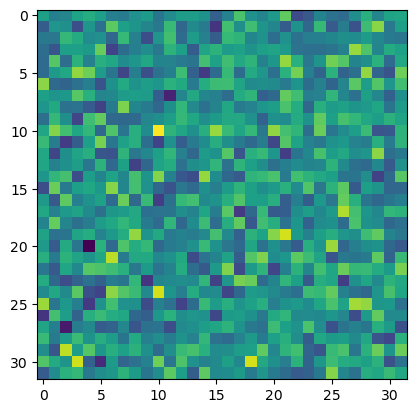

image at t: tensor([[602]], device='cuda:0', dtype=torch.int32)


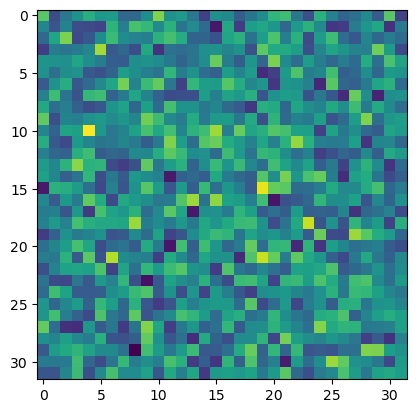

image at t: tensor([[402]], device='cuda:0', dtype=torch.int32)


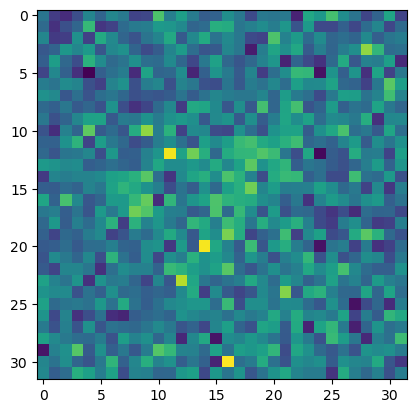

image at t: tensor([[202]], device='cuda:0', dtype=torch.int32)


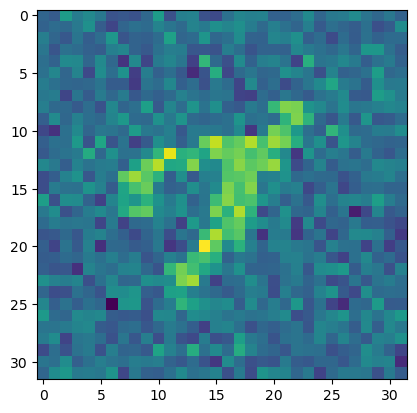

image at t: tensor([[2]], device='cuda:0', dtype=torch.int32)


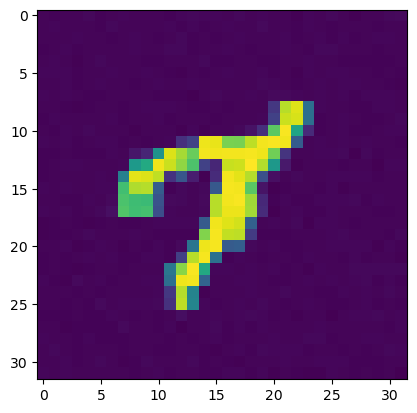

final image


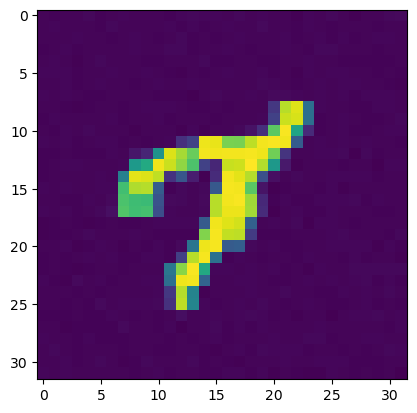

In [33]:
print("foo")
# generation for unconditional diffusion
x_curr = torch.randn(1, in_c, in_h, in_w).to(device=device)

for t in range(T - 1, 1, -1):
    t = torch.tensor([[t]], dtype=torch.int, device=device)
    x_curr = sample_next_step(x_curr, t, model)
    if (t - 2) % 200 == 0:
        print(f"image at t: {t}")
        plt.imshow(x_curr[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()

print("final image")
plt.imshow(x_curr[0].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

In [ ]:
beta_1: float = 1e-4
beta_T: float = 0.02
def get_beta_t(t: int) -> float:
    assert 1 <= t and t <= T, f"time index {t} must be in range [1, {T}]"
    return (beta_1 * (T - t) + beta_T * (t - 1)) / (T - 1)

betas: torch.Tensor = torch.Tensor([get_beta_t(t) for t in range(1, T + 1)])
alphas: torch.Tensor = torch.cumprod(1 - betas, dim=0)
betas = betas.to(device=device)
alphas = alphas.to(device=device)

In [ ]:
print(f"betas size: {betas.size()}")
print(f"alphas size: {alphas.size()}")

betas size: torch.Size([1000])
alphas size: torch.Size([1000])


In [ ]:
t = torch.tensor([[2], [3]], dtype=torch.int).to(device=device)

In [ ]:
betas[t].size()

torch.Size([2, 1])

In [ ]:
x_t = torch.randn(1, in_c, in_h, in_w).to(device=device)
print(f"x_t: {x_t.size()}")
t = torch.tensor([[999]], dtype=torch.int).cuda()

beta_t = betas[t - 1]
alpha_t = alphas[t - 1]
alpha_t_1 = alphas[t - 2]

noise_pred = model(x_t, t)
print(f"noise_pred: {noise_pred.size()}")
# conditional mean and variance
mu_t = (x_t - (beta_t / torch.sqrt(1 - alpha_t)) * model(x_t, t)) / torch.sqrt(
    1 - beta_t
)
sigma_t = torch.sqrt((1 - alpha_t_1) / (1 - alpha_t) * beta_t)

x_prev = mu_t + sigma_t * torch.randn_like(mu_t)

x_t: torch.Size([1, 1, 32, 32])
noise_pred: torch.Size([1, 1, 32, 32])


In [5]:
losses = np.load("losses/train_losses.npy")

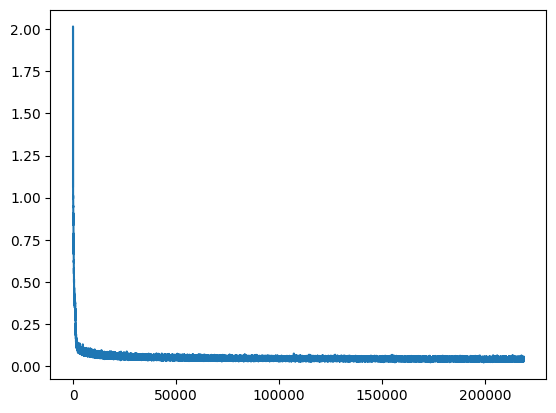

In [6]:
plt.plot(losses)

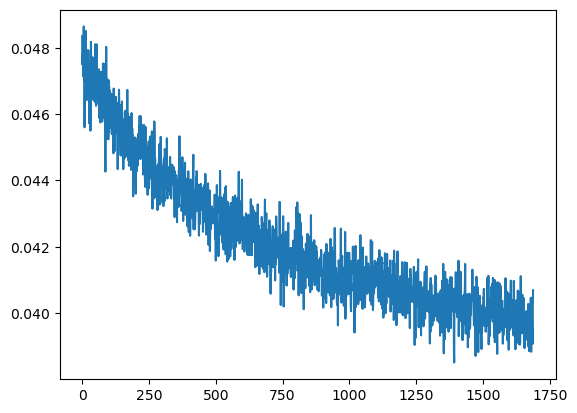

In [ ]:
plt.plot(averaged_losses[500:])

In [ ]:
len(losses)

218800

In [ ]:
averaged_losses = np.mean(losses.reshape(-1, 100), axis=1)

In [11]:
from src.model import get_embedding

In [12]:
emb = get_embedding(10, 100)

In [13]:
emb.shape

torch.Size([10, 100])

In [14]:
import matplotlib.pyplot as plt

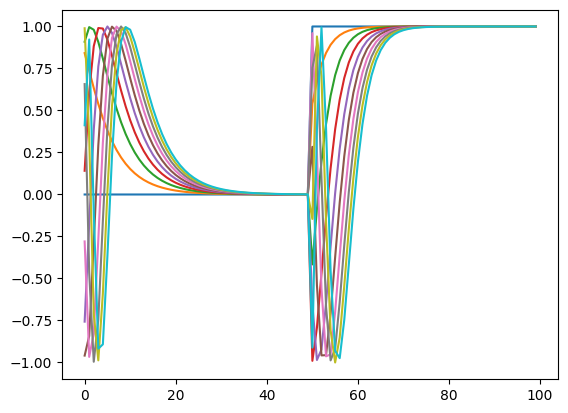

In [15]:
for i in range(10):
    plt.plot(emb[i, :])
plt.show()

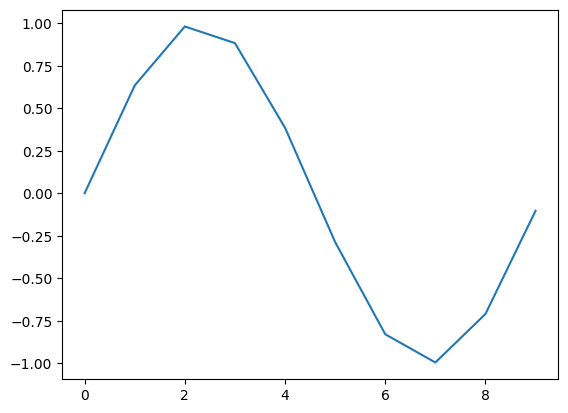

In [24]:
plt.plot(emb[:, 2])